# DENUE analysis my block -test-

This notebook covers the first steps towards an urban land use classifier. In it:
1. The DENUE database is downloaded for a specific area
2. A classification of the DENUE by activity is assigned to each point
3. Each DENUE point gets assigned to an urban block
4. An iterative process produces a Kernel Density Estimation for each activity classification and each block

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc
import zipfile

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download and read data

### Area of analysis

In [8]:
# Unzip "Distrito":
zip_path = "Distrito.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()
    print("Archivos extraídos:", zip_ref.namelist())

Archivos extraídos: ['Distrito/distrito.cpg', 'Distrito/distrito.dbf', 'Distrito/distrito.prj', 'Distrito/distrito.shp', 'Distrito/distrito.shx']


In [2]:
aoa_gdf = gpd.read_file("distrito.shp")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 2)


,id,geometry
0,1,"POLYGON ((-103.4233 20.91026, -103.42209 20.91..."


In [3]:
print(aoa_gdf.crs)

EPSG:4326


In [4]:
aoa_gdf.columns.tolist()

['id', 'geometry']

<Axes: >

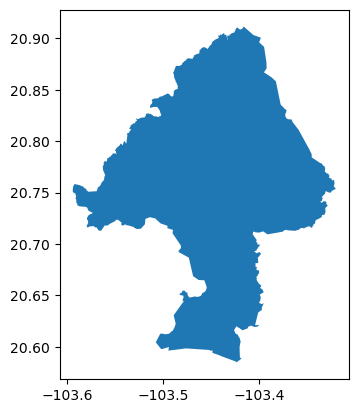

In [58]:
aoa_gdf.plot()

In [4]:
aoa_gdf = aoa_gdf.to_crs("EPSG:4326")

### DENUE

In [5]:
# Disolver

# 2. Unir geometrías y obtener WKT como string
poly_geom = aoa_gdf.dissolve().geometry.iloc[0]
poly_wkt = poly_geom.wkt  # Este sí es un string

In [6]:
print(type(poly_wkt))  # Debe ser <class 'str'>

<class 'str'>


In [7]:
print(f"Tipo de geometría: {aoa_gdf.dissolve().geometry.type.iloc[0]}")

Tipo de geometría: Polygon


In [24]:
from shapely import wkb
import binascii
from sqlalchemy import text
from aup import utils

# Consulta que devuelve WKT en lugar de geometría nativa
query_censo = f"""
SELECT
    id,
    cve_ent as entidad,
    cve_loc as localidad,
    manzana,
    cve_mun as municipio,
    latitud,
    longitud,
    codigo_act,
    ageb,
    per_ocu,
    ST_AsText(geometry) as geometry_wkt
FROM {schema}.{table}
WHERE ST_Intersects(
    geometry, 
    ST_SetSRID(ST_MakeValid(ST_GeomFromText('{poly_wkt}')), 4326)
)
"""

engine = utils.db_engine()
conn = engine.connect()

try:
    # Obtener datos como DataFrame de pandas
    df = pd.read_sql_query(text(query_censo), conn)
    
    # Convertir WKT a geometrías shapely
    from shapely import wkt
    df['geometry'] = df['geometry_wkt'].apply(wkt.loads)
    df = df.drop('geometry_wkt', axis=1)
    
    # Crear GeoDataFrame
    denue_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    print(denue_gdf.shape)
    print(denue_gdf.head())

finally:
    conn.close()
    engine.dispose()

(52127, 11)
        id entidad localidad manzana municipio    latitud    longitud  \
0  1829669      14      0001     040       120  20.777288 -103.445935   
1  1829668      14      0001     038       120  20.779729 -103.446429   
2  1704486      14      0001     005       120  20.773346 -103.446032   
3  7625437      14      0001     003       120  20.773177 -103.444999   
4  6340430      14      0001     014       120  20.775201 -103.445398   

  codigo_act  ageb            per_ocu                     geometry  
0     312112  6635     0 a 5 personas  POINT (-103.44593 20.77729)  
1     312112  6635     0 a 5 personas  POINT (-103.44643 20.77973)  
2     311830  6705     0 a 5 personas  POINT (-103.44603 20.77335)  
3     321910  6705     0 a 5 personas    POINT (-103.445 20.77318)  
4     326290  6705  51 a 100 personas    POINT (-103.4454 20.7752)  


### Census blocks

In [41]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from sqlalchemy import text
from aup import utils

schema = "sociodemografico"
table = "censo_inegi_20_mza"

# Consulta que devuelve WKT en lugar de geometría nativa
query_censo = f"""
SELECT 
"cvegeo_mza",
"pobtot",
ST_AsText(geometry) as geometry_wkt
FROM {schema}.{table}
WHERE ST_Intersects(
  geometry,
  ST_SetSRID(ST_MakeValid(ST_GeomFromText('{poly_wkt}')), 4326)
)
"""

engine = utils.db_engine()
conn = engine.connect()

try:
    # Obtener datos como DataFrame de pandas
    df = pd.read_sql_query(text(query_censo), conn)
       
    # Convertir WKT a geometrías shapely (si hay datos)
    if len(df) > 0:
        df['geometry'] = df['geometry_wkt'].apply(wkt.loads)
        df = df.drop('geometry_wkt', axis=1)
        
        # Crear GeoDataFrame
        block_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
        
        # Transformar al CRS deseado
        block_gdf = block_gdf.to_crs("EPSG:4326")
        
        print(block_gdf.shape)
        print(block_gdf.head())
        print("Sí hay datos.")
    else:
        print("No se encontraron datos que coincidan con el polígono, incluso con buffer.")
        
        # Obtener solo algunos registros para verificar que podemos acceder a la tabla
        check_query = f"""
        SELECT 
        "cvegeo_mza",
        "pobtot",
        ST_AsText(geometry) as geometry_wkt
        FROM {schema}.{table}
        LIMIT 5
        """
        check_df = pd.read_sql_query(text(check_query), conn)
        if len(check_df) > 0:
            check_df['geometry'] = check_df['geometry_wkt'].apply(wkt.loads)
            check_df = check_df.drop('geometry_wkt', axis=1)
            check_gdf = gpd.GeoDataFrame(check_df, geometry='geometry', crs="EPSG:4326")
            print("\nMuestra de algunos registros disponibles en la tabla:")
            print(check_gdf.head())
finally:
    conn.close()
    engine.dispose()

(15505, 3)
         cvegeo_mza  pobtot                                           geometry
0  1412002312079001     581  POLYGON ((-103.50348 20.80092, -103.50348 20.8...
1  1412002312079005      80  POLYGON ((-103.50516 20.8007, -103.5055 20.799...
2  1412002312079007      29  POLYGON ((-103.50674 20.80092, -103.50568 20.8...
3  1412002312079012      91  POLYGON ((-103.50683 20.80155, -103.50726 20.8...
4  1412002312079013      80  POLYGON ((-103.50773 20.7997, -103.50775 20.80...
Sí hay datos.


## Data treatment and preprocessing

### DENUE classification by activity

Clasificar las distintas actividades económicas con base en su terminación en "codigo_act" basándonos en el Directorio Estadístico Nacional de Unidades Económicas

In [42]:
# Función para clasificar según la terminación de codigo_act
def asignar_tipo(codigo):
    if pd.isna(codigo):  # Si está vacío
        return 'Sin código'
    
    # Asegurar que sea string para evaluar el código
    codigo_str = str(codigo).strip()

    if not codigo_str.isdigit():
        return 'Código inválido'
    
    # Define tus conjuntos de códigos
    industria = {'11', '21', '23', '31', '32', '33', '55'}
    
    servicios = {'22', '48', '49', '52', '53', '54', '56', '72',
                 '81'}
    
    comercio = {'43', '46'}
    
    cultural_recreativo = {'51','71'}
    
    educacion = {'61'}
    
    salud = {'62'}

    gobierno = {'93'}
    
    # Verificar si el código está en alguno de los conjuntos
    if codigo_str[:2] in industria:
        return 'Industria'
    elif codigo_str[:2] in servicios:
        return 'Servicios'
    elif codigo_str[:2] in comercio:
        return 'Comercio'
    elif codigo_str[:2] in cultural_recreativo:
        return 'Cultural_Recreativo'
    elif codigo_str[:2] in educacion:
        return 'Educación'
    elif codigo_str[:2] in salud:
        return 'Salud'
    elif codigo_str[:2] in gobierno:
        return 'Gobierno'
    else:
        return 'Desconocido'

# Aplica la función al DataFrame
denue_gdf['tipo_act'] = denue_gdf['codigo_act'].apply(asignar_tipo)

In [43]:
denue_gdf.head(3)

,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3
1,1829668,14,0001,038,120,20.779729,-103.446429,312112,6635,0 a 5 personas,POINT (-103.44643 20.77973),Industria,3
2,1704486,14,0001,005,120,20.773346,-103.446032,311830,6705,0 a 5 personas,POINT (-103.44603 20.77335),Industria,3


In [44]:
denue_gdf["tipo_act"].unique()

array(['Industria', 'Comercio', 'Servicios', 'Educación', 'Salud',
       'Cultural_Recreativo', 'Gobierno'], dtype=object)

In [45]:
len(denue_gdf[denue_gdf['tipo_act'] == 'Desconocido'])

0

### DENUE occupied personel

Contabilizar cuántas personas hay ejerciendo cada actividad económica

In [46]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [47]:
denue_gdf['per_ocu_num'] = denue_gdf.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))
denue_gdf.head(2)

,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3
1,1829668,14,0001,038,120,20.779729,-103.446429,312112,6635,0 a 5 personas,POINT (-103.44643 20.77973),Industria,3


### DENUE to blocks

Create CVEGEO code for each DENUE

In [49]:
denue_gdf['cvegeo_mza'] = (
    denue_gdf['entidad'].astype(str).str[:2] +
    denue_gdf['municipio'].astype(str).str[:3] +
    denue_gdf['localidad'].astype(str).str[:4] +
    denue_gdf['ageb'].astype(str).str[:4] +
    denue_gdf['manzana'].astype(str).str[:3]
)
print(denue_gdf.shape)
denue_gdf.head(2)

(52127, 14)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3,1412000016635040
1,1829668,14,0001,038,120,20.779729,-103.446429,312112,6635,0 a 5 personas,POINT (-103.44643 20.77973),Industria,3,1412000016635038


In [50]:
denue_gdf.cvegeo_mza.apply(len).min() # checks if every element has a 16 character length

16

Test if every DENUE is assigned to a block

In [51]:
denue_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], on='cvegeo_mza', how='inner').pobtot.isna().sum()

0

### Distance from DENUE to block centroids

In [52]:
# 1. Crear GeoDataFrame de manzanas con centroides únicos
block_cnt = block_gdf.copy()
block_cnt['cnt_geometry'] = block_cnt['geometry'].centroid

/tmp/ipykernel_14988/3273052898.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  block_cnt['cnt_geometry'] = block_cnt['geometry'].centroid


In [53]:
# 2. Merge block centroid geometry to DENUE gdf
denue_gdf = pd.merge(
    denue_gdf,
    block_cnt[['cvegeo_mza', 'cnt_geometry']],
    on=['cvegeo_mza'],
    how='inner'
)
print(denue_gdf.shape)
denue_gdf.head(2)

(51885, 15)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3,1412000016635040,POINT (-103.44613 20.77705)
1,9013984,14,0001,040,120,20.776958,-103.445862,465111,6635,0 a 5 personas,POINT (-103.44586 20.77696),Comercio,3,1412000016635040,POINT (-103.44613 20.77705)


In [54]:
# 3. Calcular la distancia de cada punto al centroide de su manzana
denue_gdf['distancia'] = denue_gdf['geometry'].distance(denue_gdf['cnt_geometry'])

/tmp/ipykernel_14988/4255178002.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  denue_gdf['distancia'] = denue_gdf['geometry'].distance(denue_gdf['cnt_geometry'])


In [55]:
# 4. Calcular d_mean por manzana
denue_to_cnt = denue_gdf.groupby(
    ['cvegeo_mza']
)['distancia'].mean().reset_index(name='d_mean')
print(denue_to_cnt.shape)
denue_to_cnt.head(2)

(8061, 2)


,cvegeo_mza,d_mean
0,1409704240975002,0.000824
1,1409704240975028,0.000608


In [56]:
# Add average distance to each block centroid
denue_gdf = denue_gdf.merge(denue_to_cnt, on='cvegeo_mza')
print(denue_gdf.shape)
denue_gdf.head(2)

(51885, 17)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3,1412000016635040,POINT (-103.44613 20.77705),0.000307,0.000278
1,9013984,14,0001,040,120,20.776958,-103.445862,465111,6635,0 a 5 personas,POINT (-103.44586 20.77696),Comercio,3,1412000016635040,POINT (-103.44613 20.77705),0.000286,0.000278


<Axes: >

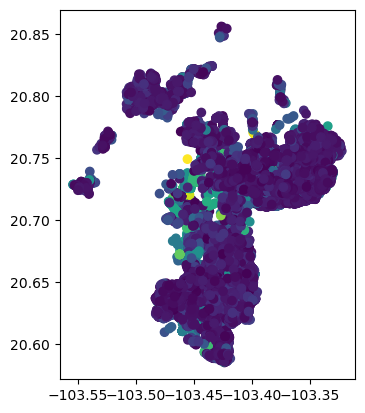

In [57]:
denue_gdf.plot('d_mean')

## Kernel density analysis

#### Single block test

In [60]:
# Obtener el conteo por manzana
conteo_por_manzana = denue_gdf.groupby('cvegeo_mza').size().reset_index(name='conteo')

# Encontrar la manzana con máximo conteo
max_row = conteo_por_manzana.loc[conteo_por_manzana['conteo'].idxmax()]
cvegeo_max = max_row['cvegeo_mza']

In [61]:
block_test = block_gdf.loc[block_gdf.cvegeo_mza==cvegeo_max].copy()

denue_test = denue_gdf.loc[denue_gdf.cvegeo_mza==cvegeo_max].copy()
denue_test = denue_test.reset_index(drop=True)

print(denue_test.shape)
denue_test.head(2)

(298, 17)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,6873851,14,0001,015,120,20.651590,-103.402214,713299,066A,51 a 100 personas,POINT (-103.40221 20.65159),Cultural_Recreativo,75,141200001066A015,POINT (-103.40176 20.65035),0.001320,0.001378
1,1811329,14,0001,015,120,20.651738,-103.402117,722511,066A,6 a 10 personas,POINT (-103.40212 20.65174),Servicios,8,141200001066A015,POINT (-103.40176 20.65035),0.001432,0.001378


In [62]:
denue_test.per_ocu_num.unique()

array([ 75,   8,   3,  20,  40, 175])

In [65]:
# Ejecutar el KDE solo sobre esos puntos
spatial_kernel_density(
    points=denue_test,
    radius = denue_test['d_mean'].mean()/2,
    output_path="figureskde_manzana_prueba_todos_los_predios.tif",
    output_pixel_size=5,
    output_driver="GTiff",
    weight_col="per_ocu_num", # Número de personas por ocupación
)

### Iterative analysis

Analysis for every block and economic activity classification

In [ ]:
output_dir = 'figureskde_manzana_prueba_todos_los_predios.tif'
for idx, manzana in block_gdf.iterrows():
    # Filtrar puntos DENUE dentro de la manzana y con la actividad deseada
    cvegeo_mza = block_gdf.loc[idx].cvegeo_mza
    denue_block = denue_gdf.loc[denue_gdf.cvegeo_mza == cvegeo_mza].copy()

    # Saltar si no hay puntos que cumplan ambos criterios
    if denue_block.empty:
        continue

    # Nombre de salida con ID y nombre de actividad
    for act in denue_block.tipo_act.unique():
        output_file = f"{output_dir}kde_mnz_{cvegeo_mza}_{act}.tif"
        denue_act = denue_block.loc[denue_block.tipo_act==act].copy()
        denue_act = denue_act.reset_index(drop=True)

    
        # Ejecutar el KDE
        spatial_kernel_density(
            points=denue_act,
            radius = (denue_block['d_mean'].mean() / 2),
            output_path=output_file,
            output_pixel_size=1.0,
            output_driver="GTiff",
            weight_col="per_ocu_num",
        )
